In [1]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns

#misc
import gc
import time
import warnings
import string
import re

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#nlp
import nltk
from nltk.corpus import stopwords
#import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss, confusion_matrix, classification_report, roc_curve, auc

%matplotlib inline

print("modules loaded")

modules loaded


In [2]:
#importing the dataset
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [1]:
print("Training set: ", train.shape)
print("Test set: ", test.shape)

train.head()

NameError: name 'train' is not defined

In [4]:
test.fillna(' ',inplace=True)
gc.collect()

11

### Text pre-processing

In [ ]:
#https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view
# Aphost lookup dict
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [ ]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [5]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [6]:
corpus=merge.comment_text
corpus.shape

(312735,)

In [ ]:
start_time=time.time()

clean_corpus=corpus.apply(lambda x :clean(x))

end_time=time.time()
print("total time till Cleaning",end_time-start_time)

In [23]:
vec_unigram = TfidfVectorizer(max_features=10000,
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=True,sublinear_tf=False,
            stop_words = 'english', dtype=np.float32)

vec_unigram.fit(corpus)
features_1 = np.array(vec_unigram.get_feature_names())
features_1.shape

(10000,)

In [24]:
train_unigrams =  vec_unigram.transform(corpus.iloc[:train.shape[0]])
test_unigrams = vec_unigram.transform(corpus.iloc[train.shape[0]:])

In [26]:
vec_bigram = TfidfVectorizer(max_features=10000,
            strip_accents='unicode', analyzer='word',ngram_range=(1,2),
            use_idf=1,smooth_idf=True,sublinear_tf=False,
            stop_words = 'english', dtype=np.float32)

vec_bigram.fit(corpus)
features_2 = np.array(vec_bigram.get_feature_names())
features_2.shape

(10000,)

In [28]:
train_bigram =  vec_bigram.transform(corpus.iloc[:train.shape[0]])
test_bigram = vec_bigram.transform(corpus.iloc[train.shape[0]:])

In [30]:
vec_char = TfidfVectorizer(max_features=10000, analyzer='char',ngram_range=(1,5), 
                            use_idf=1, smooth_idf=True, sublinear_tf=False, 
                           stop_words = 'english', dtype=np.float32)

vec_char.fit(corpus)
features_3 = np.array(vec_char.get_feature_names())
features_3.shape

(10000,)

In [32]:
train_char_feats =  vec_char.transform(corpus.iloc[:train.shape[0]])
test_char_feats = vec_char.transform(corpus.iloc[train.shape[0]:])

### Feature selection

In [33]:
y_classes = list(train.columns.values)[2:]
y_classes

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [34]:
y = train[y_classes]
y.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [35]:
x_train = sparse.hstack([train_unigrams, train_bigram, train_char_feats])
x_test = sparse.hstack([test_unigrams, test_bigram, test_char_feats])

del train_unigrams, train_bigram, train_char_feats, test_unigrams, test_bigram, test_char_feats
gc.collect()

285

In [36]:
x_train

<159571x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 115172897 stored elements in COOrdinate format>

In [ ]:
## Indirect features

#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

### Learning

In [58]:
prd = np.zeros((x_test.shape[0],len(y_classes)))
lrs = []

for i,col in enumerate(y_classes):
    print(i, col)
    lr = LogisticRegression(C=1,random_state = i,class_weight = 'balanced')
    lr.fit(x_train, y[col])
    lrs.append(lr)
    prd[:,i] = lr.predict_proba(x_test)[:,1]    

0 toxic
1 severe_toxic
2 obscene
3 threat
4 insult
5 identity_hate


### Validation

In [61]:
col_index = 5
col_name = y_classes[col_index]
print("Column:", col_name)

pred =  lrs[col_index].predict(x_train)
print('\nConfusion matrix\n', confusion_matrix(y[col_name], pred))
print(classification_report(y[col_name], pred))

Column: identity_hate

Confusion matrix
 [[155698   2468]
 [     0   1405]]
             precision    recall  f1-score   support

          0       1.00      0.98      0.99    158166
          1       0.36      1.00      0.53      1405

avg / total       0.99      0.98      0.99    159571



Column: identity_hate


Text(0.5,1,'ROC')

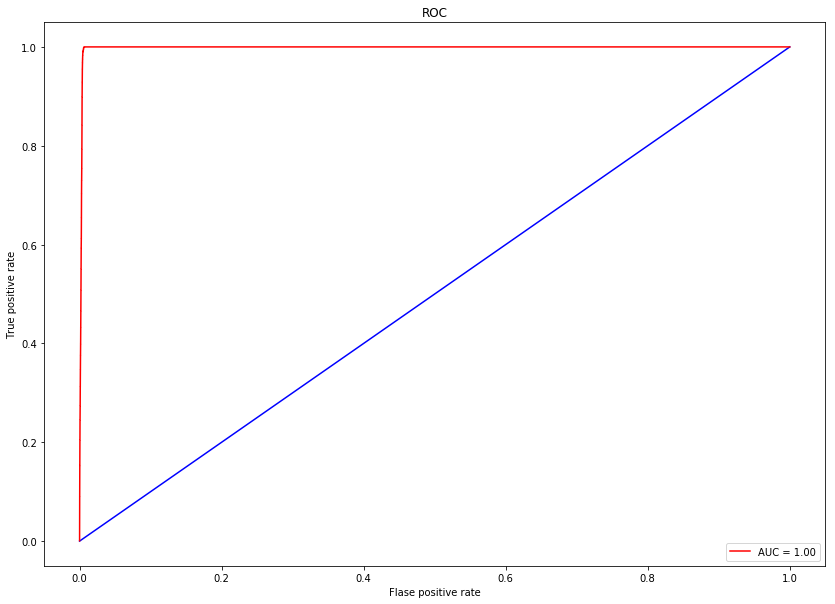

In [62]:
col_index = 5
col_name = y_classes[col_index]
print("Column:",col)

pred_pro = lrs[col_index].predict_proba(x_train)[:,1]
fpr, tpr, thresh = roc_curve(y[col_name], pred_pro)
auc_val = auc(fpr, tpr)

plt.figure(figsize=(14,10))
plt.plot([0,1], [0,1], color='b')
plt.plot(fpr, tpr, color='r', label= 'AUC = %.2f'%auc_val)
plt.legend(loc='lower right')
plt.xlabel('Flase positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')

### Submission

In [63]:
prd_1 = pd.DataFrame(prd, columns=y_classes)
submit = pd.concat([test['id'], prd_1],axis=1)
submit.to_csv('../submissions/toxic_lr_30k_c_1.csv', index=False)
submit.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999999,0.958418,0.999999,0.675844,0.999729,0.992367
1,0000247867823ef7,0.008324,0.002784,0.000887,0.000294,0.009595,0.008739
2,00013b17ad220c46,0.023124,0.002636,0.045351,0.000201,0.012208,0.005670
3,00017563c3f7919a,0.006905,0.011624,0.003022,0.000958,0.003349,0.000311
4,00017695ad8997eb,0.035995,0.004991,0.015873,0.001147,0.024621,0.000907


### Records

#### identity_hate

* Logistic with 10 x 3 with C=10   - LB: 0.9683

    * 0 | 1.00 | 0.99 | 1.00 | 158166
    * 1 | 0.63 | 1.00 | 0.77 | 1405
    
* Logistic with 10 x 3 with C=20   - LB: 0.9646

    * 0       1.00      1.00      1.00    158166
    * 1       0.72      1.00      0.84      1405
    
* Logistic with 10 x 3 with C=5   - LB: 0.9717

    * 0       1.00      0.99      1.00    158166
    * 0.54      1.00      0.70      1405
    
* Logistic with 10 x 3 with C=1  - LB: 0.9766
    * 0       1.00      0.98      0.99    158166
    * 1       0.36      1.00      0.53      1405

#### toxic

* Logistic with 10 x 3 with C=10

    * 0 | 1.00 | 0.97 | 0.99 | 144277
    * 1 | 0.80 | 1.00 | 0.89 | 15294
    
* Logistic with 10 x 3 with C=20
    * 0 | 1.00 | 0.98 | 0.99 | 144277
    * 1 | 0.83 | 1.00 | 0.91 | 15294
    
* Logistic with 10 x 3 with C=5
    * 0       1.00      0.97      0.98    144277
    * 1       0.77      1.00      0.87     15294
    
* Logistic with 10 x 3 with C=1    
    * 0       1.00      0.96      0.98    144277
    * 1       0.71      0.98      0.82     15294